In [6]:

import os
import json
import glob
import copy
import numpy as np
import pylab as pl
import seaborn as sns
import pandas as pd


from scipy import stats as spstats

#from pipeline.python.classifications import bootstrap_fit_tuning_curves as osi
from pipeline.python.classifications import bootstrap_osi as osi
from pipeline.python.classifications import experiment_classes as util
from pipeline.python.utils import natural_keys, label_figure

In [7]:
%matplotlib notebook

# TEST GRATINGS:

In [8]:
rootdir = '/n/coxfs01/2p-data'
animalid = 'JC084' #'JC059'
session = '20190522' #'20190227'
fov = 'FOV1_zoom2p0x' #'FOV4_zoom4p0x'
traceid = 'traces001' #'traces001'
response_type = 'dff'


In [9]:
# renames = glob.glob(os.path.join(rootdir, 'JC*', '20*', '*zoom2p0x*', '*gratings*', 
#                                  'traces', 'traces001*', 'tuning', 'fit-dff_responsive-ROC-thr0.05_boot-100-resample-60',
#                                 '*bootstrap_params.json'))
# print(len(renames))

# for r in renames:
#     basedir = os.path.split(r)[0]
#     with open(r, 'r') as f:
#         params = json.load(f)
#     if params['directory'] != basedir:
#         params['directory'] = basedir
#         with open(r, 'w') as f:
#             json.dump(params, f, indent=4,)
        

# Create Experiment Obj

In [12]:
reload(util)
reload(osi)

/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/experiment_classes.py:18: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to u'nbAgg' by the following code:
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/julian

<module 'pipeline.python.classifications.bootstrap_osi' from '/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/bootstrap_osi.pyc'>

In [13]:

exp = util.Gratings(animalid, session, fov, traceid=traceid, rootdir=rootdir)
exp.print_info()

... [JC084|20190522|FOV1_zoom2p0x] creating gratings object
... getting data paths - name: gratings
... renaming experiment to run name: combined_gratings_static
************* Experiment Object info *************
Name: combined_gratings_static
Experiment type: gratings
Animalid: JC084
Session: 20190522
FOV: FOV1_zoom2p0x
roi-id, trace-id: rois001, traces001
('Data source:', '/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/combined_gratings_static/traces/traces001_55a5cc_traces001_7eef99_traces001_809b80_traces001_fbc03e/data_arrays/datasets.npz')
No data loaded yet.
**************************************************


In [28]:
roi_list, nrois_total = exp.get_responsive_cells(responsive_test=responsive_test, responsive_thr=responsive_thr)
print(len(roi_list))

... getting responsive cells (test: nstds, thr: 10.00')
127


In [29]:
estats = exp.get_stats(responsive_test=responsive_test, responsive_thr=responsive_thr)

... [combined_gratings_static] Loading roi stats and cell list...
... loading data array


/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/experiment_classes.py:999: RuntimeWarning: invalid value encountered in divide
  F0 = np.nanmean(dset['corrected'][:] / dset['dff'][:] )


... offset: 644.22
... adjusting for equal reps / condn...
... updating self
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')


In [30]:
estats.nrois == nrois_total

True

In [31]:
#roi_list = estats.rois
print("Found %i responsive cells (%s, thr=%.2f)" % (len(roi_list), responsive_test, responsive_thr))

Found 127 responsive cells (nstds, thr=10.00)


# Set output summary stats dir

In [32]:
summarydir = glob.glob(os.path.join(rootdir, exp.animalid, exp.session, exp.fov, exp.name,
                           'traces', '%s*' % exp.traceid, 'summary_stats', responsive_test))[0]

print(summarydir)

/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/combined_gratings_static/traces/traces001_55a5cc_traces001_7eef99_traces001_809b80_traces001_fbc03e/summary_stats/nstds


In [33]:
data_identifier = '|'.join([exp.animalid, exp.session, exp.fov, exp.traceid, responsive_test])


# Look at overall distN of responses

In [34]:
def hist_roi_stat(gdf, metric='dff', roi_list=None, ax=None):
    if roi_list is None:
        roi_list = estats.gdf.groups.keys()
    if ax is None:
        fig, ax = pl.subplots()

    max_dffs_by_config = [gdf.get_group(roi).groupby(['config']).mean()['dff'].max() for roi in roi_list]
    sns.distplot(max_dffs_by_config, ax=ax)
    sns.despine(ax=ax, trim=True, offset=2)
    ax.set_xlabel(metric)
    ax.set_ylabel('kde')
    return ax

<IPython.core.display.Javascript object>


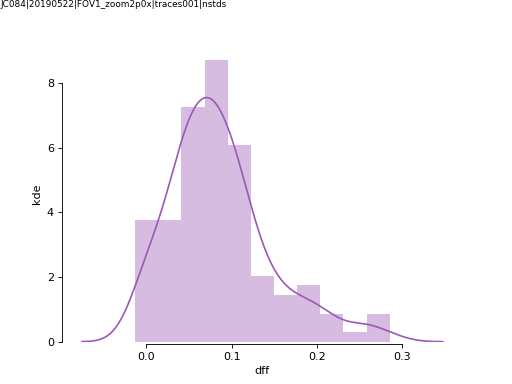

In [35]:
fig, ax = pl.subplots()
ax = hist_roi_stat(estats.gdf, metric='dff', roi_list=roi_list, ax=ax)

label_figure(fig, data_identifier)
pl.savefig(os.path.join(summarydir, 'hist-avg-dff-best-cfg.png'))


# Load tuning fits

In [19]:
# Get responsivity stats:
responsive_test = 'nstds'
responsive_thr = 10J
n_stds = 2.5

# Tuning params
n_bootstrap_iters = 1000
n_resamples = 20
n_intervals_interp = 3
min_cfgs_above = 2

In [22]:
create_new = False
plot_rois = False
goodness_thr = 0.66
n_processes = 8

In [77]:
bootresults, fitparams = exp.get_tuning(create_new=create_new, n_processes=n_processes,
                                           responsive_test=responsive_test, responsive_thr=responsive_thr,
                                           n_stds=n_stds, min_cfgs_above=min_cfgs_above,
                                           n_bootstrap_iters=n_bootstrap_iters, n_resamples=n_resamples,
                                           n_intervals_interp=n_intervals_interp, plot_rois=plot_rois)


...getting OSI results: fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20
Loading existing fits.


#### Test fit quality with goodness-of-fit metric

In [36]:
goodness_thr = 0.66

In [43]:
rmetrics, goodrois = exp.evaluate_fits(bootresults, fitparams, goodness_thr=goodness_thr, rootdir=rootdir)
print(rmetrics.shape)

Loading existing fits.
94 cells fit at least 1 tuning curve.
31 cells have good fits (thr >= 0.66)
(31, 11)


In [73]:
#fitdf['preferred_theta'] = fitdf['preferred_theta'] % 360.

In [38]:
rmetrics.head()

,asi,dsi,response_null,response_offset,response_pref,sigma,theta_pref,r2,cell,r2comb,gof
9,0.232276,0.047759,0.034741,0.017054,0.040564,27.735139,131.319018,0.824547,9.0,0.865719,0.671130
17,0.130685,0.121358,0.020018,0.064275,0.072029,24.393538,60.225476,0.857708,17.0,0.900635,0.736837
25,0.254741,0.093042,0.075636,-0.007213,0.094497,41.051257,183.778070,0.872817,25.0,0.804473,0.719747
30,0.541039,0.335307,0.043448,0.008413,0.124077,22.500424,269.138484,0.968607,30.0,0.967263,0.939913
45,0.295832,0.054202,0.057046,0.019518,0.067456,28.847034,192.916245,0.924761,45.0,0.958727,0.857131


# Set output dir to tuning dir

In [39]:
tuningdir = fitparams['directory']
print tuningdir

/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/combined_gratings_static/traces/traces001_55a5cc_traces001_7eef99_traces001_809b80_traces001_fbc03e/tuning/fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20


# Visualize tuning characteristics of well-fit neurons

In [40]:

fit_desc = os.path.split(fitparams['directory'])[-1]
data_identifier = '|'.join([exp.animalid, exp.session, exp.fov, exp.traceid, fit_desc])


In [42]:
df = rmetrics[rmetrics['cell'].isin(goodrois)]
print(df.shape)

(31, 11)


In [44]:
df.head()

,asi,dsi,response_null,response_offset,response_pref,sigma,theta_pref,r2,cell,r2comb,gof
9,0.232276,0.047759,0.034741,0.017054,0.040564,27.735139,131.319018,0.824547,9.0,0.865719,0.671130
17,0.130685,0.121358,0.020018,0.064275,0.072029,24.393538,60.225476,0.857708,17.0,0.900635,0.736837
25,0.254741,0.093042,0.075636,-0.007213,0.094497,41.051257,183.778070,0.872817,25.0,0.804473,0.719747
30,0.541039,0.335307,0.043448,0.008413,0.124077,22.500424,269.138484,0.968607,30.0,0.967263,0.939913
45,0.295832,0.054202,0.057046,0.019518,0.067456,28.847034,192.916245,0.924761,45.0,0.958727,0.857131


#### Sort by DSI

In [55]:
def rois_sortby(fitdf, sort_by='DSI', plot_metric='theta_pref', roi_list=None, descending=True):
    if roi_list is not None:
        df = fitdf[fitdf['cell'].isin(roi_list)]
    else:
        df = fitdf.copy()
    
    if 'theta' in sort_by:
        dsi_values = df.groupby(['cell'])[plot_metric].apply(np.deg2rad).apply(spstats.circmean).apply(np.rad2deg)
    elif 'rad' in sort_by:
        dsi_values = df.groupby(['cell'])[plot_metric].apply(np.deg2rad).apply(spstats.circmean).apply(np.rad2deg)
    else:
        dsi_values = df.groupby(['cell']).mean()[sort_by]
    if descending:
        dsi_sorted_ixs = np.argsort(dsi_values).values[::-1] #Sort from biggest to smallest
    else:
        dsi_sorted_ixs = np.argsort(dsi_values).values #Sort from smallest to biggest
    rsort_by_dsi = np.array(dsi_values.index.tolist())[dsi_sorted_ixs]

    return rsort_by_dsi


In [108]:
def split_even_odd_trials(bootresults, rsort_by):
    evens = []
    odds = []
    for roi in rsort_by:
        evens_t = np.vstack([bootr['data']['responses'][0::2].mean().values for stimparam, bootr in bootresults[roi].items()]).mean(axis=0)
        odds_t = np.vstack([bootr['data']['responses'][1::2].mean().values for stimparam, bootr in bootresults[roi].items()]).mean(axis=0)
        evens.append(evens_t)
        odds.append(odds_t)
    evens = np.array(evens)
    odds = np.array(odds)
    return evens, odds

In [107]:
def plot_even_odd_trials(evens, odds, rsort_by, cmap='inferno', tested_values=None):

    fig, axes = pl.subplots(1,2, sharex=True, sharey=True)
    cbar_ax = fig.add_axes([.85, .3, .03, .4])
    vmin = min([evens.min(), odds.min()])
    vmax = max([evens.max(), odds.max()])

    sns.heatmap(evens, ax=axes[0], cbar=True, vmin=vmin, vmax=vmax, cbar_ax=cbar_ax, cmap=cmap)
    axes[0].set_title('evens')
    axes[0].set_xticklabels(tested_values, rotation=45)

    sns.heatmap(odds, ax=axes[1], cbar=0, vmin=vmin, vmax=vmax, cbar_ax=None, cmap=cmap)
    axes[1].set_title('odds')
    axes[1].set_xticklabels(tested_values, rotation=45)
    axes[1].tick_params(labelsize=8)

    axes[0].set_ylabel('cell')
    axes[0].set_yticks(np.arange(0, len(rsort_by))) 
    axes[0].set_yticklabels([int(i) for i in rsort_by], rotation=45) #(tested_values, rotation=45)
    axes[0].tick_params(axis='y', labelsize=6)
    cbar_ax.set_title(response_type)

    pl.subplots_adjust(wspace=0.05, right=0.80)
    
    return fig

# Compare even and odd trials for cells with good tuning fits

In [88]:
tested_values = np.array(estats.sdf['ori'].unique().astype(float))

<IPython.core.display.Javascript object>


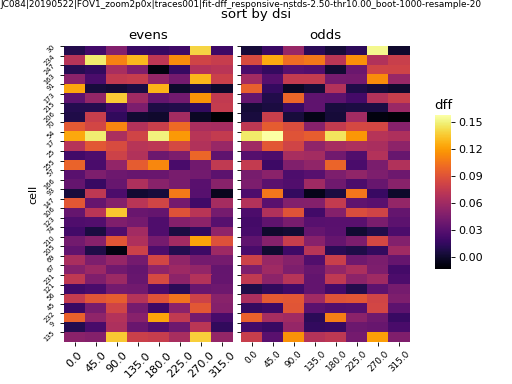

gof-0.66_tuning-on-evens-vs-odd-trials_sort-by-dsi


In [112]:
# Sort by DSI
sort_by = 'dsi'
rsort_by = rois_sortby(df, sort_by=sort_by, plot_metric='theta_pref', roi_list=None, descending=True)
evens, odds = split_even_odd_trials(bootresults, rsort_by)

fig = plot_even_odd_trials(evens, odds, rsort_by, cmap=cmap, tested_values=tested_values)
fig.suptitle('sort by %s' % sort_by)

label_figure(fig, data_identifier)

figname = 'gof-%.2f_tuning-on-evens-vs-odd-trials_sort-by-%s' % (goodness_thr, sort_by)
pl.savefig(os.path.join(tuningdir, 'evaluation', '%s.png' % figname))
print figname

<IPython.core.display.Javascript object>


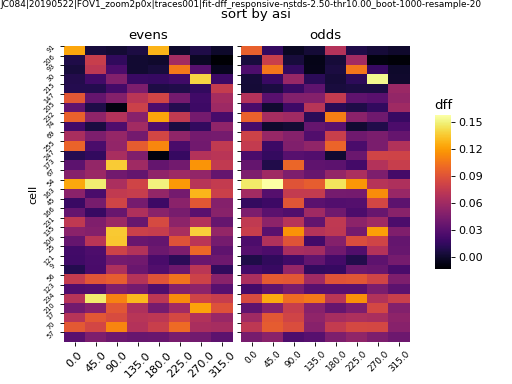

gof-0.66_tuning-on-evens-vs-odd-trials_sort-by-asi


In [113]:
# Sort by ASI
sort_by = 'asi'
rsort_by = rois_sortby(df, sort_by=sort_by, plot_metric='theta_pref', roi_list=None, descending=True)
evens, odds = split_even_odd_trials(bootresults, rsort_by)

fig = plot_even_odd_trials(evens, odds, rsort_by, cmap=cmap, tested_values=tested_values)
fig.suptitle('sort by %s' % sort_by)

label_figure(fig, data_identifier)

figname = 'gof-%.2f_tuning-on-evens-vs-odd-trials_sort-by-%s' % (goodness_thr, sort_by)
pl.savefig(os.path.join(tuningdir, 'evaluation', '%s.png' % figname))
print figname

#### Sort by preferred theta

<IPython.core.display.Javascript object>


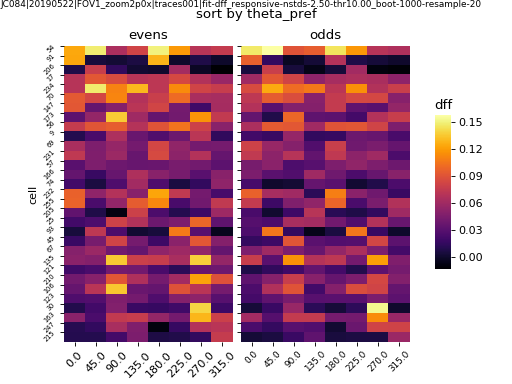

gof-0.66_tuning-on-evens-vs-odd-trials_sort-by-theta_pref


In [116]:
# Sort by DSI
sort_by = 'theta_pref'
rsort_by = rois_sortby(df, sort_by=sort_by, plot_metric='theta_pref', roi_list=None, descending=False)
evens, odds = split_even_odd_trials(bootresults, rsort_by)

fig = plot_even_odd_trials(evens, odds, rsort_by, cmap=cmap, tested_values=tested_values)
fig.suptitle('sort by %s' % sort_by)

label_figure(fig, data_identifier)

figname = 'gof-%.2f_tuning-on-evens-vs-odd-trials_sort-by-%s' % (goodness_thr, sort_by)
pl.savefig(os.path.join(tuningdir, 'evaluation', '%s.png' % figname))
print figname




# figname= '%s_tuning-on-evens-vs-odd-iters_sort-by-preferredtheta' % filter_str
# pl.savefig(os.path.join(tuningdir, 'evaluation', '%s.png' % figname))
# figname

# Combine bootstrap iters and get profile of each cell

In [95]:
fitdf.head()

,ASI,DSI,cell,preferred_theta,r2,r2comb,gof
0,0.113478,0.241001,1,112.815766,0.816551,0.596873,0.515525
1,0.164272,0.118872,1,112.198196,0.687734,0.596873,0.515525
2,0.154520,0.130066,1,91.933135,0.710843,0.596873,0.515525
3,0.124664,0.158865,1,103.162950,0.815078,0.596873,0.515525
4,0.140017,0.129466,1,112.218305,0.916464,0.596873,0.515525


In [96]:
filter_good = False

In [97]:
if filter_good:
    roi_list = copy.copy(goodfits)
    filter_str = 'good-fits-%.2f' % goodness_thr
else:
    roi_list = copy.copy(allfits)
    filter_str = 'all-fits'



,ASI,DSI,gof,r2_comb,r_null,r_offset,r_pref,sigma,theta_pref
1,0.139821,0.148313,0.515525,0.596873,0.024139,-0.011653,0.033378,58.189125,106.967776
5,0.238047,0.239732,0.667976,0.780260,0.007484,0.013430,0.028899,32.777538,341.510634
7,0.120311,0.121794,0.647583,0.753529,0.024739,-0.007150,0.033837,55.454318,88.076047
9,0.228383,0.035577,0.738153,0.875168,0.033583,0.019594,0.036970,25.547037,86.912078
10,0.072446,0.138486,0.124104,0.134878,0.018910,-0.010689,0.032146,78.173020,121.491937


In [77]:
def aggregate_fit_results(fitdata, fitdf):
    tuningdata = []

    for roi, fitd in fitdf.groupby(['cell']):
        popt = osi.get_average_params_over_iters(fitdata['results_by_iter'][roi])    
        r_pref, r_null, theta_pref, sigma, r_offset = popt
        asi = fitd['ASI'].mean()
        dsi = fitd['DSI'].mean()
        r2comb = fitd['r2comb'].unique()[0]
        gof = fitd['gof'].unique()[0]
        tuningdata.append( pd.DataFrame({'ASI': asi,
                                         'DSI': dsi,
                                          'r_pref': r_pref,
                                          'r_null': r_null,
                                          'theta_pref': theta_pref,
                                          'sigma': sigma,
                                          'r_offset': r_offset,
                                        'r2_comb': r2comb,
                                        'gof': gof
                                        }, index=[roi]) )

    tuning = pd.concat(tuningdata, axis=0)
    tuning['theta_pref'] = tuning['theta_pref'] % 360.

    return tuning

In [78]:
tuning = aggregate_fit_results(fitdata, fitdf)

In [79]:
tuning.head()

,ASI,DSI,gof,r2_comb,r_null,r_offset,r_pref,sigma,theta_pref
1,0.139821,0.148313,0.515525,0.596873,0.024139,-0.011653,0.033378,58.189125,106.967776
5,0.238047,0.239732,0.667976,0.780260,0.007484,0.013430,0.028899,32.777538,341.510634
7,0.120311,0.121794,0.647583,0.753529,0.024739,-0.007150,0.033837,55.454318,88.076047
9,0.228383,0.035577,0.738153,0.875168,0.033583,0.019594,0.036970,25.547037,86.912078
10,0.072446,0.138486,0.124104,0.134878,0.018910,-0.010689,0.032146,78.173020,121.491937


'gof0.66'

# Look at distN of each metric

<IPython.core.display.Javascript object>


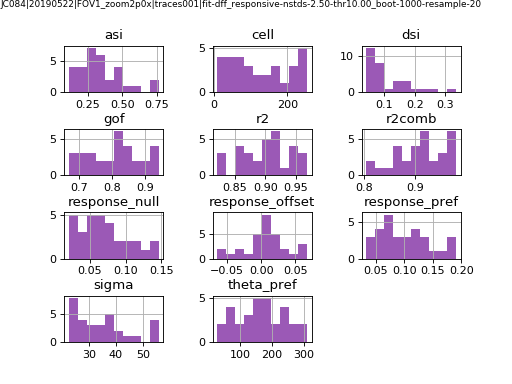

hist-each-param_gof-0.66


In [119]:

fig = rmetrics.hist()
pl.subplots_adjust(hspace=0.8, wspace=0.5)

label_figure(fig[0][0].figure, data_identifier)

figname = 'hist-each-param_gof-%.2f' % goodness_thr
print(figname)
pl.savefig(os.path.join(tuningdir, 'evaluation', '%s.png' % figname))

# Compare metrics pair-wise

In [120]:
from pandas.plotting import scatter_matrix


<IPython.core.display.Javascript object>


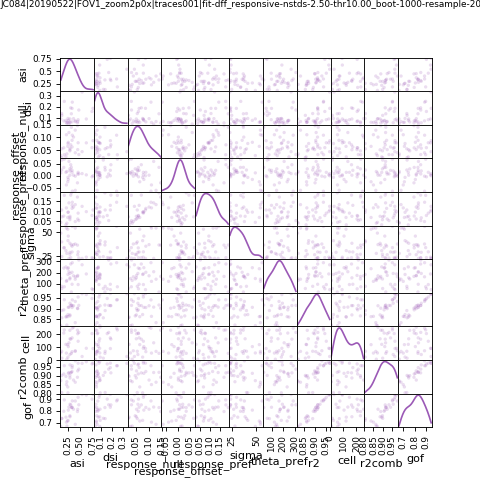

scatter-matrix_gof-0.66


In [121]:

fig = scatter_matrix(rmetrics, alpha=0.2, figsize=(6, 6), diagonal='kde')

label_figure(fig[0][0].figure, data_identifier)
figname = 'scatter-matrix_gof-%.2f' % goodness_thr
print(figname)
pl.savefig(os.path.join(tuningdir, 'evaluation', '%s.png' % figname))

# Find closest matching tested theta to plot histogram of preferred angles

In [127]:
from collections import Counter
from matplotlib import patches

def hist_gratings_stats(tuningdf, all_categories, colorvals, variable='pref_theta', ax=None,
                        thresh=0.33, ori_metric='ASI', show_selective=False):
        
    best_ori_vals = tuningdf[variable]
    best_ori_vals_selective = tuningdf[tuningdf[ori_metric] >= thresh][variable]
    
    ori_counts_all = Counter(best_ori_vals)
    if all_categories is not None:
        for catg in all_categories:
            if catg not in ori_counts_all:
                ori_counts_all[catg] = 0
                
    ori_counts_selective = Counter(best_ori_vals_selective)
    for ori in ori_counts_all.keys():
        if ori not in ori_counts_selective.keys():
            ori_counts_selective[ori] = 0
   
    bar_palette = colorvals.as_hex()
    
    if ax is None:
        fig, ax = pl.subplots()
    
    sns.barplot(sorted(ori_counts_all.keys()), [ori_counts_all[c] for c in sorted(ori_counts_all.keys())], palette=bar_palette, ax=ax)
    ax.tick_params(axis='x', which='both', length=0)

    if show_selective:    
        ax2 = ax.twinx()
        sns.barplot(sorted(ori_counts_all.keys()), [ori_counts_selective[c] for c in sorted(ori_counts_all.keys())], palette=bar_palette, ax=ax2)
        ax2.set_ylim(ax.get_ylim())
        hatch = '//' #itertools.cycle(['/', '//', '+', '-', 'x', '\\', '*', 'o', 'O', '.'])
        for i, bar in enumerate(ax2.patches):
            bar.set_hatch(hatch)
        ax2.set_yticklabels([])
        ax2.tick_params(axis='both', which='both', length=0)
    
        hatch1 = patches.Patch( facecolor='white', hatch=r'\\\\',label='%s > %.2f' % (ori_metric, thresh))
        ax2.legend(handles = [hatch1], loc=1)
        
    sns.despine(trim=True, offset=4)
        
    return ax

In [137]:
tested_values

array([   0.,   45.,   90.,  135.,  180.,  225.,  270.,  315.])

In [141]:
tested_thetas = list(tested_values.copy())
tested_thetas.append(360)

tested_thetas = np.array(tested_thetas)

rmetrics['theta_tested'] = [tested_thetas[np.where(np.abs(t-tested_thetas)== np.min(np.abs(t-tested_thetas)))[0][0]] % 360. \
                            for t in rmetrics['theta_pref']]
tested_thetas = tested_thetas[0:-1]

In [142]:
rmetrics.head()

,asi,dsi,response_null,response_offset,response_pref,sigma,theta_pref,r2,cell,r2comb,gof,theta_tested
9,0.232276,0.047759,0.034741,0.017054,0.040564,27.735139,131.319018,0.824547,9.0,0.865719,0.671130,135.0
17,0.130685,0.121358,0.020018,0.064275,0.072029,24.393538,60.225476,0.857708,17.0,0.900635,0.736837,45.0
25,0.254741,0.093042,0.075636,-0.007213,0.094497,41.051257,183.778070,0.872817,25.0,0.804473,0.719747,180.0
30,0.541039,0.335307,0.043448,0.008413,0.124077,22.500424,269.138484,0.968607,30.0,0.967263,0.939913,270.0
45,0.295832,0.054202,0.057046,0.019518,0.067456,28.847034,192.916245,0.924761,45.0,0.958727,0.857131,180.0


<IPython.core.display.Javascript object>


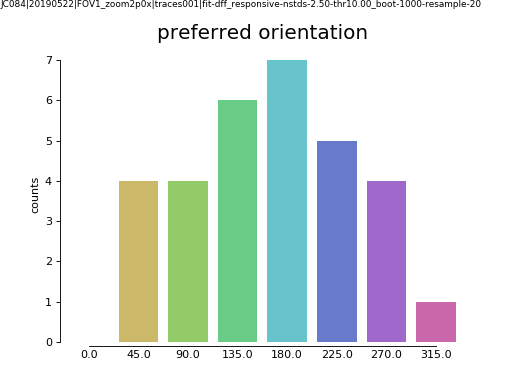

hist-tested-oris_gof-0.66


In [143]:


cmap = 'hls'
noris = len(tested_values)

fig, ax = pl.subplots()
colorvals = sns.color_palette(cmap, noris) # len(gratings_sconfigs))
#show_selective = False if filter_gof else True
if tested_thetas.shape[0] > 0:
    hist_gratings_stats(rmetrics, tested_thetas, colorvals, ax=ax, variable='theta_tested',
                       thresh=goodness_thr, ori_metric='gof', show_selective=False)
ax.set_title('preferred orientation', fontsize=18)
ax.set_ylabel('counts')
        
    
    
label_figure(fig, data_identifier)
figname = 'hist-tested-oris_gof-%.2f' % goodness_thr
print(figname)
pl.savefig(os.path.join(tuningdir, '%s.png' % figname))


# Preferred axis polar

In [ ]:
rmetrics['']